# SARIMA(p,d,q)(P,D,Q)m model

In [1]:
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (9,6)

## Exploring seasonality 

In [3]:
# source: https://raw.githubusercontent.com/plotly/datasets/master/monthly-milk-production-pounds.csv

df = pd.read_csv('data/monthly-milk-production-pounds.csv')
df.columns = ['Month', 'Milk']

df.head()

,Month,Milk
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


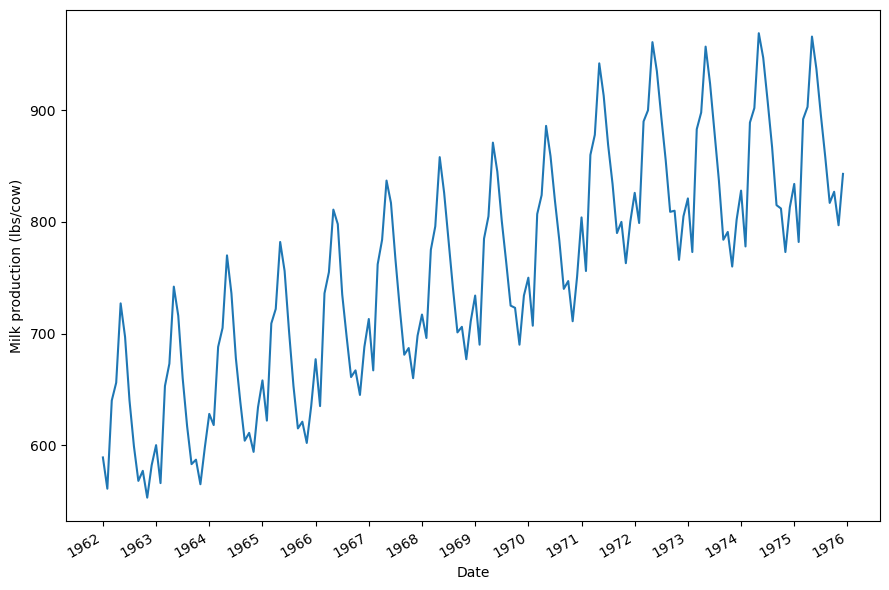

In [4]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Milk'])
ax.set_xlabel('Date')
ax.set_ylabel('Milk production (lbs/cow)')

plt.xticks(np.arange(0, 179, 12), np.arange(1962, 1977, 1))

fig.autofmt_xdate()
plt.tight_layout()

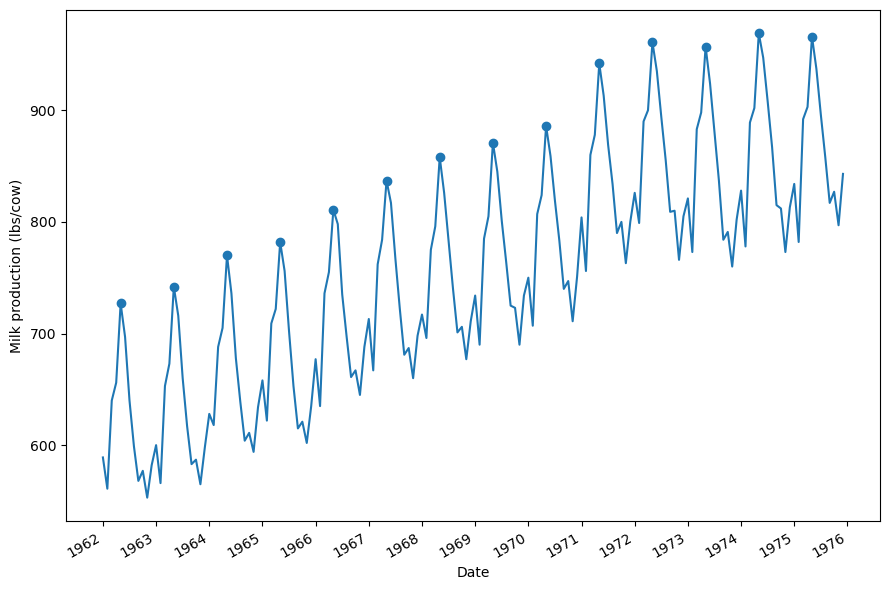

In [5]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Milk'], markevery=np.arange(4, 169, 12), marker='o')
ax.set_xlabel('Date')
ax.set_ylabel('Milk production (lbs/cow)')

plt.xticks(np.arange(0, 179, 12), np.arange(1962, 1977, 1))

fig.autofmt_xdate()
plt.tight_layout()

In the figure above, notice how the series peaks around the same month every year. This is a clear indication of seasonality.

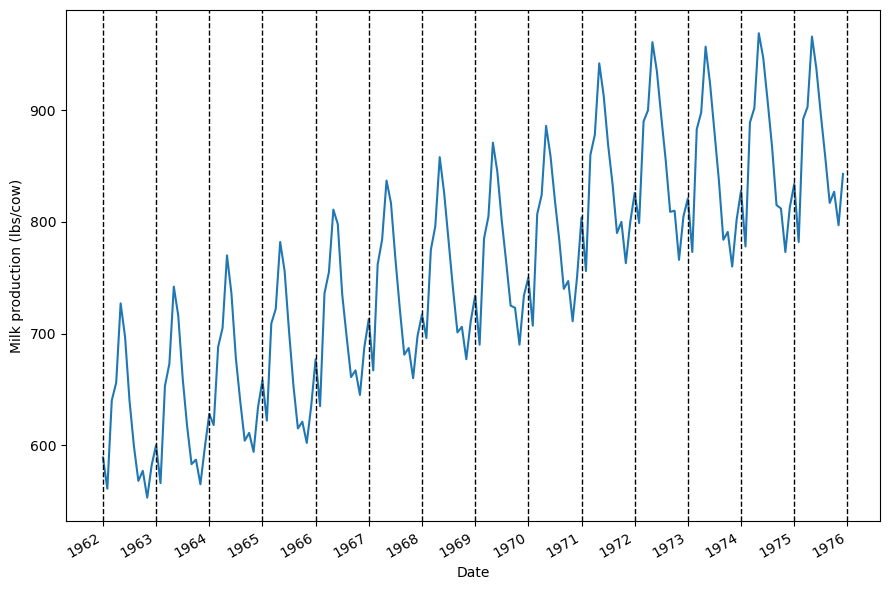

In [6]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Milk'])
for i in np.arange(0, 169, 12):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Milk production (lbs/cow)')

plt.xticks(np.arange(0, 179, 12), np.arange(1962, 1977, 1))

fig.autofmt_xdate()
plt.tight_layout()

In the figure above, each vertical dashed line represent the end of the year. We can see that the general pattern in a year is repeated every year, suggesting a yearly seasonality.

## Decomposition 

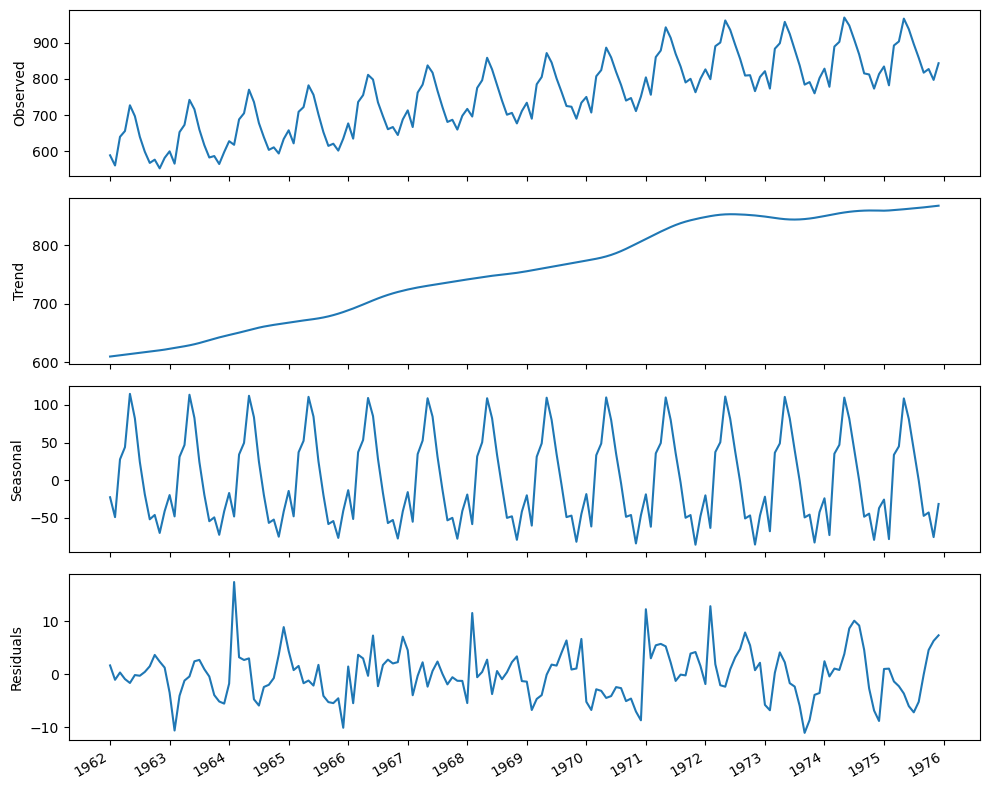

In [7]:
decomposition = STL(df['Milk'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 179, 12), np.arange(1962, 1977, 1))

fig.autofmt_xdate()
plt.tight_layout()

## Forecasting with SARIMA 

In [8]:
ad_fuller_result = adfuller(df['Milk'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.3038115874221312
p-value: 0.6274267086030308


### Differencing and stationarity

In [9]:
df_diff = np.diff(df['Milk'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.054995558653062
p-value: 0.03006800400178634


In [10]:
df_diff_seasonal_diff = np.diff(df_diff, n=12)

ad_fuller_result = adfuller(df_diff_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -26.568403962754697
p-value: 0.0


### Define test set 

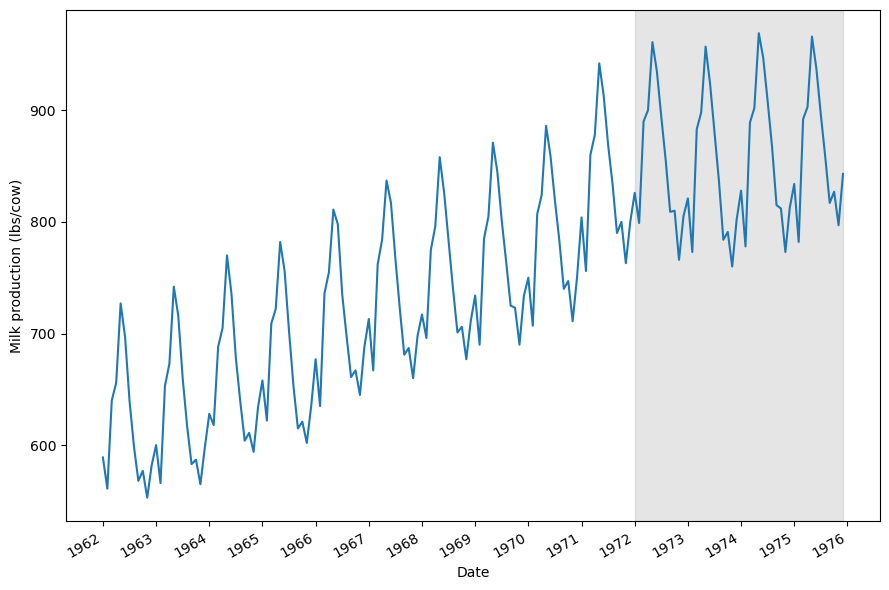

In [11]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Milk'])
ax.set_xlabel('Date')
ax.set_ylabel('Milk production (lbs/cow)')
ax.axvspan(120, 167, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 179, 12), np.arange(1962, 1977, 1))

fig.autofmt_xdate()
plt.tight_layout()

In [12]:
train = df[:-48]
test = df[-48:]

### Model selection with AIC 

In [13]:
def SARIMA_gridsearch(endog, min_p, max_p, min_q, max_q, min_P, max_P, min_Q, max_Q, d, D, s):
    
    all_p = range(min_p, max_p+1, 1)
    all_q = range(min_q, max_q+1, 1)
    all_P = range(min_P, max_P+1, 1)
    all_Q = range(min_Q, max_Q+1, 1)
    
    all_orders = list(product(all_p, all_q, all_P, all_Q))
    
    print(f'Fitting {len(all_orders)} unique models')
    
    results = []
    
    for order in tqdm_notebook(all_orders):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s)).fit(disp=False)
        except:
            continue
            
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [23]:
min_p = 0
max_p = 4
min_q = 0
max_q = 4

min_P = 0
max_P = 4
min_Q = 0
max_Q = 4

d = 1
D = 1
s = 12

result_df = SARIMA_gridsearch(train['Milk'], min_p, max_p, min_q, max_q, min_P, max_P, min_Q, max_Q, d, D, s)
result_df.head()

Fitting 625 unique models


  0%|          | 0/625 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(0, 4, 0, 1)",740.719959
1,"(0, 1, 0, 1)",741.559091
2,"(1, 0, 0, 1)",741.910895
3,"(2, 1, 0, 1)",742.072935
4,"(1, 4, 0, 1)",742.645811


In [14]:
SARIMA_model = SARIMAX(train['Milk'], order=(0,1,4), seasonal_order=(0,1,1,12))
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 Milk   No. Observations:                  120
Model:             SARIMAX(0, 1, 4)x(0, 1, [1], 12)   Log Likelihood                -364.360
Date:                              Thu, 05 Jan 2023   AIC                            740.720
Time:                                      14:42:15   BIC                            756.757
Sample:                                           0   HQIC                           747.221
                                              - 120                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3622      0.103     -3.519      0.000      -0.564      -0.160
ma.L2          0.05

### Residuals analysis 

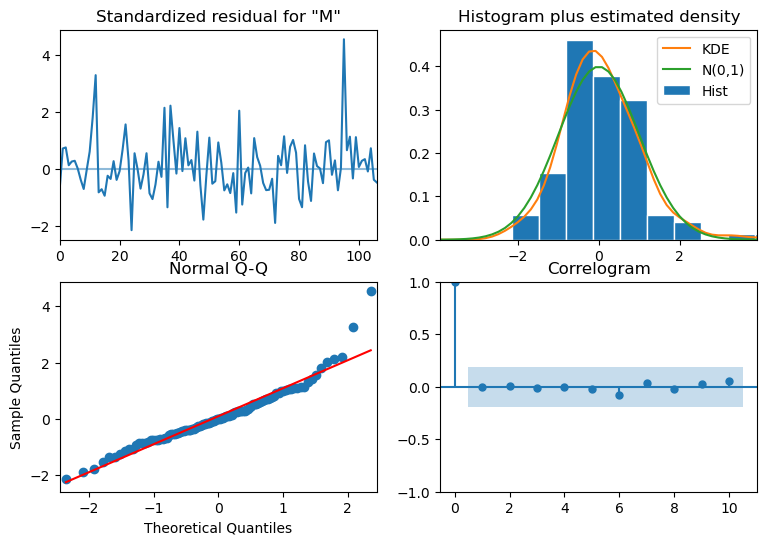

In [15]:
SARIMA_model_fit.plot_diagnostics();

In [16]:
def ljung_box_test(residuals, is_seasonal, period):
    
    if is_seasonal:
        lb_df = acorr_ljungbox(residuals, period=period)
    else:
        max_lag = min([10, len(residuals)/5])
        
        lb_df = acorr_ljungbox(residuals, np.arange(1, max_lag+1, 1))

    fig, ax = plt.subplots()
    ax.plot(lb_df['lb_pvalue'], 'b-', label='p-values')
    ax.hlines(y=0.05, xmin=1, xmax=len(lb_df), color='black')
    plt.tight_layout()
    
    if all(pvalue > 0.05 for pvalue in lb_df['lb_pvalue']):
        print('All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated')
    else:
        print('At least one p-value is smaller than 0.05')

At least one p-value is smaller than 0.05


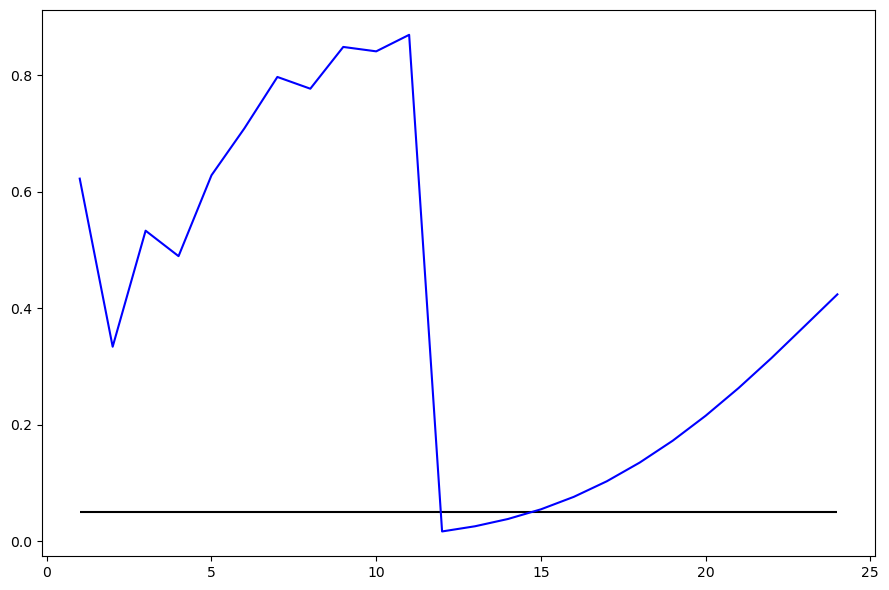

In [17]:
residuals = SARIMA_model_fit.resid

ljung_box_test(residuals, True, 12)

### Forecasting 

In [18]:
def rolling_predictions(df, train_len, horizon, window, period, method):
    
    TOTAL_LEN = train_len + horizon
    
    seasonal_steps = int((window/period))
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, TOTAL_LEN, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        
        return pred_mean[:horizon]

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, TOTAL_LEN, window):
            last_value = diff[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value[:horizon]
    
    elif method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, TOTAL_LEN, window):
            last_season = df[:i][-period:].values
            pred_last_season.extend(last_season for _ in range(seasonal_steps))

        pred_last_season = np.array(pred_last_season).reshape(1, -1)
        
        return pred_last_season[0][:horizon]
    
    if method == 'SARIMA':
        pred_SARIMA = []
        
        for i in range(train_len, TOTAL_LEN, window):
            model = SARIMAX(df[:i], order=(0,1,4), seasonal_order=(0,1,1,12))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean[-window:]
            pred_SARIMA.extend(oos_pred)
            
        return pred_SARIMA[:horizon]

In [19]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)

windows = [12, 24, 36, 48]

for window in windows:
    pred_last_season = rolling_predictions(df['Milk'], TRAIN_LEN, HORIZON, window, 12, 'last_season')
    pred_SARIMA = rolling_predictions(df['Milk'], TRAIN_LEN, HORIZON, window, 12, 'SARIMA')

    pred_df[f'pred_last_season_{window}'] = pred_last_season
    pred_df[f'pred_SARIMA_{window}'] = pred_SARIMA

pred_df.head()

,Month,Milk,pred_last_season_12,pred_SARIMA_12,pred_last_season_24,pred_SARIMA_24,pred_last_season_36,pred_SARIMA_36,pred_last_season_48,pred_SARIMA_48
120,1972-01,826,804,836.947904,804,836.947904,804,836.947904,804,836.947904
121,1972-02,799,756,791.727754,756,791.727754,756,791.727754,756,791.727754
122,1972-03,890,860,890.761697,860,890.761697,860,890.761697,860,890.761697
123,1972-04,900,878,909.982547,878,909.982547,878,909.982547,878,909.982547
124,1972-05,961,942,972.969161,942,972.969161,942,972.969161,942,972.969161


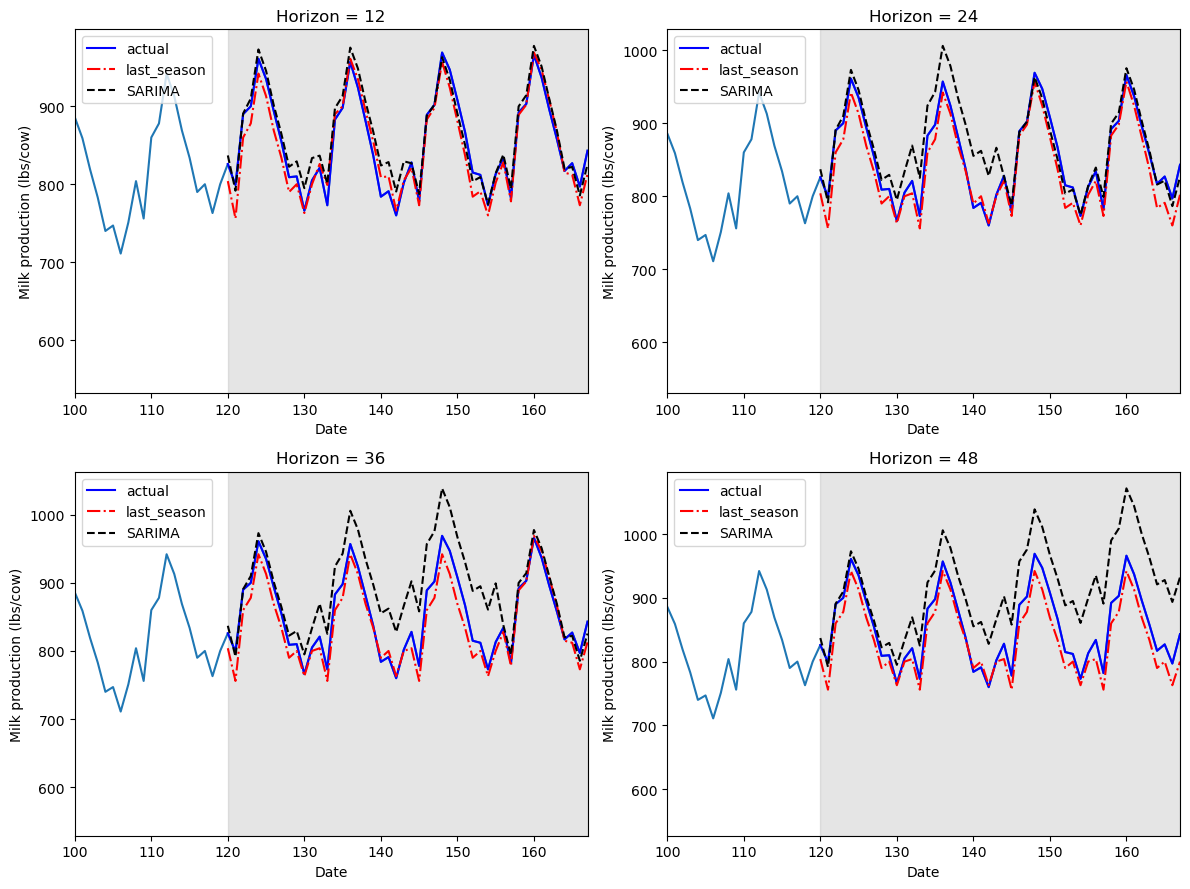

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    
    ax.plot(df['Milk'])
    ax.plot(pred_df['Milk'], 'b-', label='actual')
    ax.plot(pred_df[f'pred_last_season_{windows[i]}'], 'r-.', label='last_season')
    ax.plot(pred_df[f'pred_SARIMA_{windows[i]}'], 'k--', label='SARIMA')
    
    ax.legend(loc=2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Milk production (lbs/cow)')
    ax.axvspan(120, 167, color='#808080', alpha=0.2)
    ax.set_xlim(100, 167)
    ax.set_title(f'Horizon = {windows[i]}')
    
plt.tight_layout()

#### Evaluation 

In [22]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [23]:
mape_naive_seasonal_12 = mape(pred_df['Milk'], pred_df['pred_last_season_12'])
mape_SARIMA_12 = mape(pred_df['Milk'], pred_df['pred_SARIMA_12'])

mape_naive_seasonal_24 = mape(pred_df['Milk'], pred_df['pred_last_season_24'])
mape_SARIMA_24 = mape(pred_df['Milk'], pred_df['pred_SARIMA_24'])

mape_naive_seasonal_36 = mape(pred_df['Milk'], pred_df['pred_last_season_36'])
mape_SARIMA_36 = mape(pred_df['Milk'], pred_df['pred_SARIMA_36'])

mape_naive_seasonal_48 = mape(pred_df['Milk'], pred_df['pred_last_season_48'])
mape_SARIMA_48 = mape(pred_df['Milk'], pred_df['pred_SARIMA_48'])

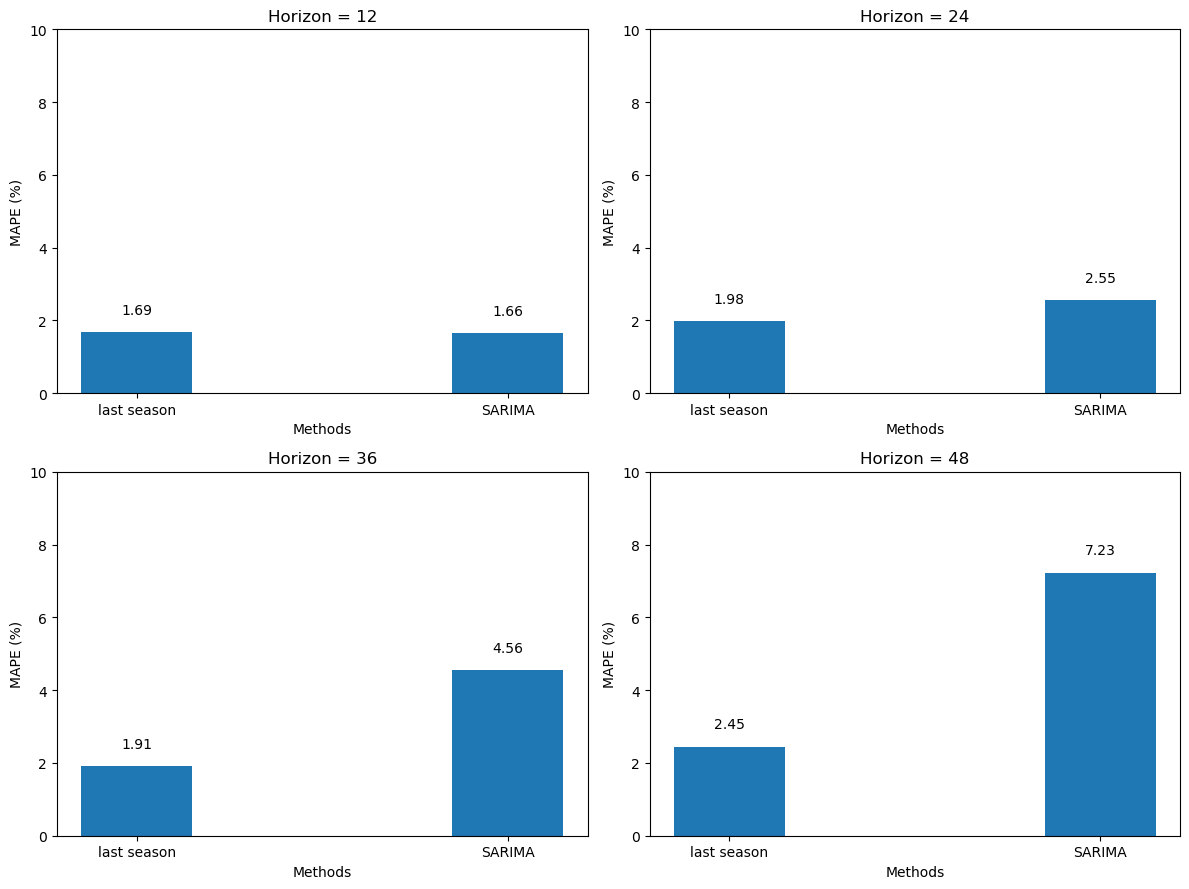

In [24]:
mapes_naive_seasonal = [mape_naive_seasonal_12, mape_naive_seasonal_24, mape_naive_seasonal_36, mape_naive_seasonal_48]
mapes_SARIMA = [mape_SARIMA_12, mape_SARIMA_24, mape_SARIMA_36, mape_SARIMA_48]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

x = ['last season', 'SARIMA']
width = 0.3

for i, ax in enumerate(axes.flatten()):
    
    y = [mapes_naive_seasonal[i], mapes_SARIMA[i]]
    ax.bar(x, y, width)
    ax.set_xlabel('Methods')
    ax.set_ylabel('MAPE (%)')
    ax.set_ylim(0, 10)
    ax.set_title(f'Horizon = {windows[i]}')    
    
    for index, value in enumerate(y):
        ax.text(x=index, y=value+0.5, s=str(value), ha='center')

plt.tight_layout()